## Insider Trades Analysis

Trades made by insiders are filed with the SEC on Form 4s. A large literature shows that these trades contain information about future stock performance.

Quandl data: Core US Insiders Data (SHARADAR/SF2)

In [1]:
import numpy as np
import pandas as pd

In [2]:
# import quandl
# import pandas as pd
# quandl.ApiConfig.api_key = "YOUR KEY HERE"

In [3]:
# # Pull zipped file
# table = 'SF2'
# quandl.export_table('SHARADAR/' + table)
# print("finished download: ' + table")

In [4]:
# # Unzip and load dataset
# from zipfile import ZipFile
# with ZipFile('./SHARADAR_'+table+'.zip', 'r') as zipObj:
#     name = zipObj.namelist()[0]
#     zipObj.extractall()
# df = pd.read_csv(name, low_memory=False)
# df = df.rename(columns={"table": "table_"})

In [5]:
# df.to_pickle('D:\Dropbox\Data-Driven Investments Lab\sf2.pkl')

### Read from pickle



In [6]:
trds = pd.read_pickle('https://www.dropbox.com/scl/fi/ipf2jtp1myui9r9liz4s3/sf2.pkl?rlkey=wue99ag1t04edb0u2z729o8ej&dl=1')

In [7]:
# Subset for trades
trds = trds[trds.formtype=='4']

In [8]:
# Subset for open-market purchases and sales
trds = trds[(trds.transactioncode=='P') | (trds.transactioncode=='S')]

In [9]:
# Check transactionshares signing (transactionshares usually positive for purchases and negative for sales)
trds.groupby('transactioncode').transactionshares.describe()

,count,mean,std,min,25%,50%,75%,max
transactioncode,,,,,,,,
P,653784.0,251413.432571,8.127580e+06,-5.135352e+08,216.0,1380.0,9000.0,2.400000e+09
S,1608267.0,-122488.550982,1.626094e+07,-1.000000e+10,-9455.0,-2000.0,-400.0,-1.000000e+00


In [10]:
trds['filingdate']=pd.to_datetime(trds.filingdate)

In [11]:
cols = ['ticker', 'filingdate', 'issuername', 'ownername',
       'officertitle', 'transactiondate', 'transactioncode',
       'transactionshares', 'transactionpricepershare',
       'transactionvalue']
trds[cols].head()

,ticker,filingdate,issuername,ownername,officertitle,transactiondate,transactioncode,transactionshares,transactionpricepershare,transactionvalue
31,CMC,2024-01-18,COMMERCIAL METALS CO,SMITH BARBARA,Executive Chairman,2024-01-16,S,-142806.0,49.890,7124591.0
108,OMI,2024-01-18,OWENS MINOR INC,LEON JONATHAN A,SVP Corporate Treasurer,2024-01-17,S,-7500.0,18.080,135600.0
113,AGYS,2024-01-18,AGILYSYS INC,MAK CAPITAL ONE LLC,NaN,2024-01-16,S,-13356.0,75.079,1002755.0
114,AGYS,2024-01-18,AGILYSYS INC,MAK CAPITAL ONE LLC,NaN,2024-01-17,S,-32958.0,75.391,2484737.0
115,AGYS,2024-01-18,AGILYSYS INC,MAK CAPITAL ONE LLC,NaN,2024-01-18,S,-87500.0,77.626,6792275.0


### Create horizon measure of Akbas, Jiang, Koch (JF 2020)

Investment horizon of an insider is the average annual net order flow over the 10 calendar years prior to month $t$.  For insider $i$ at firm $j$:

$$ HOR_{ijt} = \left| \frac{\sum_{y=\text{year}(t)-10}^{\text{year}(t-1)} IOF_{ijy}}{N}  \right| \times (-1) \,,$$

where annual net insider order flow of insider $i$ is:
$$ IOF_{ijy}= \frac{P_{ijy} - S_{ijy}}{P_{ijy} + S_{ijy}}\,.$$
$P$ is the number of shares purchases, $S$ is the number of shared sold, and $N$ is the number of calendar years the insider traded over the 10 years prior to month $t$.
AJK require trading in at least 4 of the past 10 years.




In [12]:
# Calculate insider-permno order flow each year
trds['year'] =trds.filingdate.dt.year
iof = trds.groupby(['ownername','ticker','year','transactioncode'])[['transactionshares']].sum()
iof = iof.unstack(level='transactioncode')
iof.columns = ['P','S']
iof = iof.fillna(0)
iof.S = np.abs(iof.S)
iof = (iof.P - iof.S) / (iof.P + iof.S)
iof.name='iof'
iof = pd.DataFrame(iof)
iof.head()

iof
ownername                       ticker year     
0967761 BC LTD                  AWGI   2015 -1.0
                                       2016  1.0
101105607 SASKATCHEWAN LTD      WSHE   2013  1.0
10X CAPITAL SPAC SPONSOR II LLC AAGR   2022 -1.0
                                       2023  1.0

In [13]:
# Create a DataFrame with all unique 'ID' values and a complete list of years
unique_ids = iof.reset_index()[['ownername','ticker']].drop_duplicates()
min_year   = iof.reset_index().year.unique().min()
max_year   = iof.reset_index().year.unique().max()
all_years  = pd.date_range(start=str(min_year), end=str(max_year+1), freq='Y').year
master_df  = pd.DataFrame([(i[0], i[1], y) for i in unique_ids.values for y in all_years], columns=['ownername', 'ticker','year'])

# Set the hierarchical index for the master DataFrame
master_df.set_index(['ownername', 'ticker','year'], inplace=True)

# Merge the master DataFrame with the original DataFrame to fill in missing year observations
merged_df = iof.merge(master_df, how='right', left_index=True, right_index=True)
merged_df.head()

iof
ownername      ticker year     
0967761 BC LTD AWGI   2008  NaN
                      2009  NaN
                      2010  NaN
                      2011  NaN
                      2012  NaN

In [14]:
merged_df.head(20)

iof
ownername                  ticker year     
0967761 BC LTD             AWGI   2008  NaN
                                  2009  NaN
                                  2010  NaN
                                  2011  NaN
                                  2012  NaN
                                  2013  NaN
                                  2014  NaN
                                  2015 -1.0
                                  2016  1.0
                                  2017  NaN
                                  2018  NaN
                                  2019  NaN
                                  2020  NaN
                                  2021  NaN
                                  2022  NaN
                                  2023  NaN
                                  2024  NaN
101105607 SASKATCHEWAN LTD WSHE   2008  NaN
                                  2009  NaN
                                  2010  NaN

In [15]:
# Calculate rolling statistics and horizon measure
WINDOW_LENGTH = 10

# Sort the merged DataFrame by the index to ensure proper rolling calculations
merged_df.sort_index(inplace=True)

rolling_mean = merged_df.groupby(['ownername','ticker']).rolling(WINDOW_LENGTH,min_periods=4).agg(['mean','count']).droplevel(0).droplevel(0)
rolling_mean.columns = ['iof_mean', 'iof_count']
rolling_mean['hor'] = -1 * rolling_mean.iof_mean.abs()
rolling_mean.head(20)

iof_mean  iof_count  hor
ownername                  ticker year                          
0967761 BC LTD             AWGI   2008       NaN        NaN  NaN
                                  2009       NaN        NaN  NaN
                                  2010       NaN        NaN  NaN
                                  2011       NaN        0.0  NaN
                                  2012       NaN        0.0  NaN
                                  2013       NaN        0.0  NaN
                                  2014       NaN        0.0  NaN
                                  2015       NaN        1.0  NaN
                                  2016       NaN        2.0  NaN
                                  2017       NaN        2.0  NaN
                                  2018       NaN        2.0  NaN
                                  2019       NaN        2.0  NaN
                                  2020       NaN        2.0  NaN
                                  2021       NaN        2.0  NaN
                                  2022       NaN        2.0  NaN
                                  2023       NaN        2.0  NaN
                                  2024       NaN        2.0  NaN
101105607 SASKATCHEWAN LTD WSHE   2008       NaN        NaN  NaN
                                  2009       NaN        NaN  NaN
                                  2010       NaN        NaN  NaN

In [16]:
rolling_mean[rolling_mean.hor.isnull()==False]

iof_mean  iof_count       hor
ownername       ticker year                               
10X FUND LP     GALT   2014  0.000000        4.0 -0.000000
                       2015  0.000000        4.0 -0.000000
                       2016 -0.200000        5.0 -0.200000
                       2017  0.000000        6.0 -0.000000
                       2018 -0.142857        7.0 -0.142857
...                               ...        ...       ...
ZYSKIND BARRY D MHLD   2013  1.000000        4.0 -1.000000
                       2014  1.000000        4.0 -1.000000
                       2015  1.000000        4.0 -1.000000
                       2016  1.000000        4.0 -1.000000
                       2017  1.000000        4.0 -1.000000

[218090 rows x 3 columns]

#### Create trading strength measure of Akbas, Jiang, Koch (JF 2020)

$$ STR_{ijt} = \frac{P_{ijt} - S_{ijt}}{VOL_{jt}}$$
where $VOL_{jt}$ is the total volume of shares traded by all investors in firm $j$ during week $t$.

AJK then calculate a cross-sectional ranked value of this measure $STR\_RK$.  Take the cross-section of insider-firm observations ($ij$) and rank into quintiles 0 to 4.  Divide quintile by 4 so that the lowest quintile has a value of 0 (strong insider selling) and the highest quintile has a value of 1 (strong insider purchases).


In [17]:
import datetime
def friday_of_same_week(input_date):
    days_to_friday = (4 - input_date.weekday() + 7) % 7
    friday_date = input_date + datetime.timedelta(days=days_to_friday)
    return friday_date
trds['friday'] = trds['filingdate'].apply(friday_of_same_week)

In [18]:
trds[['filingdate','year','friday']].head()

,filingdate,year,friday
31,2024-01-18,2024,2024-01-19
108,2024-01-18,2024,2024-01-19
113,2024-01-18,2024,2024-01-19
114,2024-01-18,2024,2024-01-19
115,2024-01-18,2024,2024-01-19


#### Pull weekly stock info (volume and prices)

In [19]:
from sqlalchemy import create_engine

server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver1 = 'SQL+Server'
driver2 = 'ODBC+Driver+17+for+SQL+Server'
string1 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver1}" 
string2 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver2}" 
try: 
    conn = create_engine(string1).connect()
except:
    conn = create_engine(string2).connect() 

In [20]:
sep = pd.read_sql(
    """ 
    select * from sep_weekly
    where date>='2000-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep['date'] = pd.to_datetime(sep.date)
sep.head()

,ticker,date,lastupdated,opn,high,low,volume,closeadj,closeunadj
0,A,2010-01-08,2023-12-29,30.64,31.63,30.40,2585760.0,20.153,30.96
1,A,2010-01-15,2023-12-29,30.59,31.36,30.05,3127620.0,19.821,30.45
2,A,2010-01-22,2023-12-29,30.35,31.11,29.09,3307800.0,19.938,30.63
3,A,2010-01-29,2023-12-29,29.37,29.65,27.92,3079800.0,19.170,29.45
4,A,2010-02-05,2023-12-29,28.16,29.89,28.13,4826160.0,19.203,29.50


In [21]:
# Calculate insider order imbalance
iof = trds.groupby(['ownername','ticker','friday','transactioncode'])[['transactionshares']].sum()
iof = iof.unstack(level='transactioncode')
iof.columns = ['P','S']
iof.S = np.abs(iof.S)
iof = iof.fillna(0)
iof = iof[(iof.P>0)|(iof.S>0)]
iof.head()

P          S
ownername                       ticker friday                           
0967761 BC LTD                  AWGI   2015-10-23         0.0   320000.0
                                       2016-01-22  30531915.0        0.0
101105607 SASKATCHEWAN LTD      WSHE   2013-02-01  95460000.0        0.0
10X CAPITAL SPAC SPONSOR II LLC AAGR   2022-03-11         0.0  1334339.0
                                       2023-12-08    606666.0        0.0

In [22]:
# Add in volume each month
iof = iof.reset_index().merge(sep[['ticker','date','volume']], 
                              how='inner', 
                              left_on=['ticker','friday'], 
                              right_on=['ticker','date'])
iof.head()

,ownername,ticker,friday,P,S,date,volume
0,10X CAPITAL SPAC SPONSOR II LLC,AAGR,2022-03-11,0.0,1334339.0,2022-03-11,15785.4
1,10X CAPITAL SPAC SPONSOR II LLC,AAGR,2023-12-08,606666.0,0.0,2023-12-08,295841.2
2,10X FUND LP,GALT,2010-02-05,162503.0,0.0,2010-02-05,28100.0
3,CZIRR JAMES C,GALT,2010-02-05,162503.0,0.0,2010-02-05,28100.0
4,MARTIN ROD D,GALT,2010-02-05,162503.0,0.0,2010-02-05,28100.0


In [23]:
# Calculate trading strength
iof['str'] = (iof.P - iof.S) / iof.volume

In [24]:
# Calculate (normalized) quintiles of trading strength each month
iof = iof.dropna()
iof = iof[(iof.str > -np.inf) & (iof.str< np.inf)]
iof['str_rk'] = iof.groupby(['friday'])['str'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))
iof = iof.reset_index().sort_values(['friday','str'])
iof.head()

,index,ownername,ticker,friday,P,S,date,volume,str,str_rk
308885,309129,EMORY UNIVERSITY,GOVX,2010-01-08,0.0,717500.0,2010-01-08,0.00076,-9.440789e+08,0
504315,504723,MARXE AUSTIN W GREENHOUSE DAVID M,AYRO,2010-01-08,0.0,95409.0,2010-01-08,0.69520,-1.372396e+05,0
112003,112118,BERMAN RICHARD J,LSTA,2010-01-08,0.0,137728.0,2010-01-08,14.80080,-9.305443e+03,0
504316,504724,WALKER DONALD C,AYRO,2010-01-08,0.0,6250.0,2010-01-08,0.69520,-8.990219e+03,0
280452,280681,DIKER MANAGEMENT LLC,EFOI,2010-01-08,0.0,375000.0,2010-01-08,309.14240,-1.213033e+03,0


In [25]:
iof.tail(10)

,index,ownername,ticker,friday,P,S,date,volume,str,str_rk
594890,595377,SCHORSCH NICHOLAS S,NYC,2024-01-12,1000.0,0.0,2024-01-12,1326.2,0.754034,4
636965,637519,VECTOR CAPITAL MANAGEMENT LP,LPSN,2024-01-12,1805569.0,0.0,2024-01-12,2360949.8,0.764764,4
240988,241201,CORMORANT ASSET MANAGEMENT LP,EYPT,2024-01-12,855000.0,0.0,2024-01-12,905682.0,0.944040,4
179868,180029,BVF PARTNERS L P,KYMR,2024-01-12,979014.0,0.0,2024-01-12,911004.0,1.074654,4
344783,345046,FUND 1 INVESTMENTS LLC,TLYS,2024-01-12,180702.0,0.0,2024-01-12,131235.0,1.376935,4
257326,257545,DAHL JAMES H,AXR,2024-01-12,14853.0,0.0,2024-01-12,6735.2,2.205280,4
558216,558658,PERCEPTIVE ADVISORS LLC,SLDB,2024-01-12,3410713.0,0.0,2024-01-12,1269888.4,2.685837,4
315228,315472,EVOLVE TRANSITION INFRASTRUCTURE GP LLC,SNMP,2024-01-12,1536220.0,0.0,2024-01-12,38004.8,40.421736,4
315229,315473,STONEPEAK GP HOLDINGS LP,SNMP,2024-01-12,1536220.0,0.0,2024-01-12,38004.8,40.421736,4
290989,291223,DOWNING STEVEN R,VOXX,2024-01-12,3137500.0,0.0,2024-01-12,76640.0,40.938152,4


In [26]:
iof

,index,ownername,ticker,friday,P,S,date,volume,str,str_rk
308885,309129,EMORY UNIVERSITY,GOVX,2010-01-08,0.0,717500.0,2010-01-08,7.600000e-04,-9.440789e+08,0
504315,504723,MARXE AUSTIN W GREENHOUSE DAVID M,AYRO,2010-01-08,0.0,95409.0,2010-01-08,6.952000e-01,-1.372396e+05,0
112003,112118,BERMAN RICHARD J,LSTA,2010-01-08,0.0,137728.0,2010-01-08,1.480080e+01,-9.305443e+03,0
504316,504724,WALKER DONALD C,AYRO,2010-01-08,0.0,6250.0,2010-01-08,6.952000e-01,-8.990219e+03,0
280452,280681,DIKER MANAGEMENT LLC,EFOI,2010-01-08,0.0,375000.0,2010-01-08,3.091424e+02,-1.213033e+03,0
...,...,...,...,...,...,...,...,...,...,...
257326,257545,DAHL JAMES H,AXR,2024-01-12,14853.0,0.0,2024-01-12,6.735200e+03,2.205280e+00,4
558216,558658,PERCEPTIVE ADVISORS LLC,SLDB,2024-01-12,3410713.0,0.0,2024-01-12,1.269888e+06,2.685837e+00,4
315228,315472,EVOLVE TRANSITION INFRASTRUCTURE GP LLC,SNMP,2024-01-12,1536220.0,0.0,2024-01-12,3.800480e+04,4.042174e+01,4
315229,315473,STONEPEAK GP HOLDINGS LP,SNMP,2024-01-12,1536220.0,0.0,2024-01-12,3.800480e+04,4.042174e+01,4


In [27]:
iof.head()

,index,ownername,ticker,friday,P,S,date,volume,str,str_rk
308885,309129,EMORY UNIVERSITY,GOVX,2010-01-08,0.0,717500.0,2010-01-08,0.00076,-9.440789e+08,0
504315,504723,MARXE AUSTIN W GREENHOUSE DAVID M,AYRO,2010-01-08,0.0,95409.0,2010-01-08,0.69520,-1.372396e+05,0
112003,112118,BERMAN RICHARD J,LSTA,2010-01-08,0.0,137728.0,2010-01-08,14.80080,-9.305443e+03,0
504316,504724,WALKER DONALD C,AYRO,2010-01-08,0.0,6250.0,2010-01-08,0.69520,-8.990219e+03,0
280452,280681,DIKER MANAGEMENT LLC,EFOI,2010-01-08,0.0,375000.0,2010-01-08,309.14240,-1.213033e+03,0


In [28]:
rolling_mean.head()

iof_mean  iof_count  hor
ownername      ticker year                          
0967761 BC LTD AWGI   2008       NaN        NaN  NaN
                      2009       NaN        NaN  NaN
                      2010       NaN        NaN  NaN
                      2011       NaN        0.0  NaN
                      2012       NaN        0.0  NaN

#### Combine trading strength and HOR measure

In [29]:
iof['match_year'] = iof.friday.dt.year-1


In [30]:
iof = iof.merge(rolling_mean.reset_index(), how='left',left_on=['ownername','ticker','match_year'], right_on=['ownername','ticker','year'])
iof.head()

,index,ownername,ticker,friday,P,S,date,volume,str,str_rk,match_year,year,iof_mean,iof_count,hor
0,309129,EMORY UNIVERSITY,GOVX,2010-01-08,0.0,717500.0,2010-01-08,0.00076,-9.440789e+08,0,2009,2009,NaN,NaN,NaN
1,504723,MARXE AUSTIN W GREENHOUSE DAVID M,AYRO,2010-01-08,0.0,95409.0,2010-01-08,0.69520,-1.372396e+05,0,2009,2009,NaN,NaN,NaN
2,112118,BERMAN RICHARD J,LSTA,2010-01-08,0.0,137728.0,2010-01-08,14.80080,-9.305443e+03,0,2009,2009,NaN,NaN,NaN
3,504724,WALKER DONALD C,AYRO,2010-01-08,0.0,6250.0,2010-01-08,0.69520,-8.990219e+03,0,2009,2009,NaN,NaN,NaN
4,280681,DIKER MANAGEMENT LLC,EFOI,2010-01-08,0.0,375000.0,2010-01-08,309.14240,-1.213033e+03,0,2009,2009,NaN,NaN,NaN


#### Add in next week's return

In [31]:
# Calculate returns
sep['ret'] = sep.groupby(
    "ticker", 
    group_keys=False
).closeadj.pct_change()
sep.head()

,ticker,date,lastupdated,opn,high,low,volume,closeadj,closeunadj,ret
0,A,2010-01-08,2023-12-29,30.64,31.63,30.40,2585760.0,20.153,30.96,NaN
1,A,2010-01-15,2023-12-29,30.59,31.36,30.05,3127620.0,19.821,30.45,-0.016474
2,A,2010-01-22,2023-12-29,30.35,31.11,29.09,3307800.0,19.938,30.63,0.005903
3,A,2010-01-29,2023-12-29,29.37,29.65,27.92,3079800.0,19.170,29.45,-0.038519
4,A,2010-02-05,2023-12-29,28.16,29.89,28.13,4826160.0,19.203,29.50,0.001721


In [32]:
# Lead return one week
sep['fret'] = sep.groupby(['ticker']).ret.shift(-1)
sep.head()

,ticker,date,lastupdated,opn,high,low,volume,closeadj,closeunadj,ret,fret
0,A,2010-01-08,2023-12-29,30.64,31.63,30.40,2585760.0,20.153,30.96,NaN,-0.016474
1,A,2010-01-15,2023-12-29,30.59,31.36,30.05,3127620.0,19.821,30.45,-0.016474,0.005903
2,A,2010-01-22,2023-12-29,30.35,31.11,29.09,3307800.0,19.938,30.63,0.005903,-0.038519
3,A,2010-01-29,2023-12-29,29.37,29.65,27.92,3079800.0,19.170,29.45,-0.038519,0.001721
4,A,2010-02-05,2023-12-29,28.16,29.89,28.13,4826160.0,19.203,29.50,0.001721,-0.010207


In [33]:
# Add to AJK signals
iof = iof.merge(sep[['ticker','date','fret']], 
                how='left',
                left_on=['ticker','date'], 
                right_on=['ticker','date'])
iof.head()

,index,ownername,ticker,friday,P,S,date,volume,str,str_rk,match_year,year,iof_mean,iof_count,hor,fret
0,309129,EMORY UNIVERSITY,GOVX,2010-01-08,0.0,717500.0,2010-01-08,0.00076,-9.440789e+08,0,2009,2009,NaN,NaN,NaN,-0.062500
1,504723,MARXE AUSTIN W GREENHOUSE DAVID M,AYRO,2010-01-08,0.0,95409.0,2010-01-08,0.69520,-1.372396e+05,0,2009,2009,NaN,NaN,NaN,0.035791
2,112118,BERMAN RICHARD J,LSTA,2010-01-08,0.0,137728.0,2010-01-08,14.80080,-9.305443e+03,0,2009,2009,NaN,NaN,NaN,0.013514
3,504724,WALKER DONALD C,AYRO,2010-01-08,0.0,6250.0,2010-01-08,0.69520,-8.990219e+03,0,2009,2009,NaN,NaN,NaN,0.035791
4,280681,DIKER MANAGEMENT LLC,EFOI,2010-01-08,0.0,375000.0,2010-01-08,309.14240,-1.213033e+03,0,2009,2009,NaN,NaN,NaN,0.424242


#### Test strategy of buying stocks following strongest buy/sell signal

In [34]:
str_rk_rets = iof.groupby(['str_rk','date']).fret.mean()
str_rk_rets = str_rk_rets.unstack(level='str_rk')
str_rk_rets.columns=['Lo','1','2','3','Hi']
str_rk_rets.head()

,Lo,1,2,3,Hi
date,,,,,
2010-01-08,0.021228,0.016675,0.020192,0.005680,0.050581
2010-01-15,0.001098,0.007096,-0.001047,0.012116,0.049577
2010-01-22,-0.045229,-0.038320,-0.042559,-0.008143,0.063802
2010-01-29,-0.008411,-0.004384,0.010325,0.018935,0.031448
2010-02-05,-0.029307,-0.030386,-0.020313,-0.025013,0.010004


In [35]:
str_rk_rets.mean()

Lo   -0.000317
1     0.003245
2     0.004763
3     0.005720
Hi    0.018355
dtype: float64

<AxesSubplot:xlabel='date'>

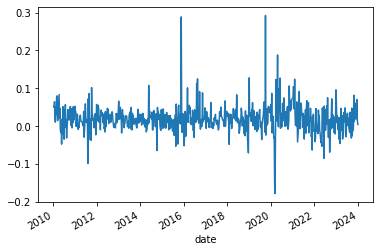

In [36]:
str_rk_rets.Hi.plot()

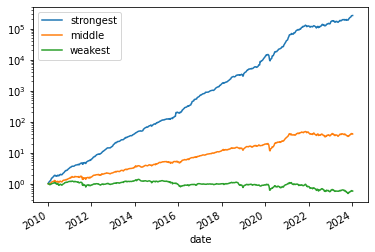

In [37]:
import matplotlib.pyplot as plt 
(1+str_rk_rets.Hi).cumprod().plot(label="strongest")
(1+str_rk_rets['3']).cumprod().plot(label="middle")
(1+str_rk_rets.Lo).cumprod().plot(label="weakest")
plt.legend()
plt.yscale('log')
plt.show()

#### Test strategy of buying stocks with strongest signal and short HOR insider

In [38]:
len(iof[iof.hor >= -0.5])

20376

In [39]:
iof = iof[iof.hor.isnull()==False]

In [40]:
iof['short_hor'] = np.where(iof.hor > -0.9, 1, 0)
rets = iof.groupby(['str_rk','short_hor','date']).fret.mean()
rets = rets.unstack(level=['short_hor'])
# str_rk_rets.columns=['Lo','1','2','3','Hi']
rets.head()

short_hor                 0         1
str_rk date                          
0      2012-01-06 -0.012990 -0.010819
       2012-01-13  0.025480  0.031902
       2012-01-20  0.018048 -0.019479
       2012-01-27  0.029585 -0.008277
       2012-02-03  0.023139  0.022215

In [41]:
iof['short_hor'] = np.where(iof.hor > -0.9, 1, 0)
rets = iof.groupby(['str_rk','short_hor','date']).fret.mean()
rets = rets.unstack(level=['short_hor'])
# str_rk_rets.columns=['Lo','1','2','3','Hi']
rets.head()

short_hor                 0         1
str_rk date                          
0      2012-01-06 -0.012990 -0.010819
       2012-01-13  0.025480  0.031902
       2012-01-20  0.018048 -0.019479
       2012-01-27  0.029585 -0.008277
       2012-02-03  0.023139  0.022215

In [42]:
shor_sells = rets.loc[(0,slice(None)),1]
shor_sells.head()

str_rk  date      
0       2012-01-06   -0.010819
        2012-01-13    0.031902
        2012-01-20   -0.019479
        2012-01-27   -0.008277
        2012-02-03    0.022215
Name: 1, dtype: float64

In [43]:
shor_buys = rets.loc[(4,slice(None)),1]
shor_buys.head()

str_rk  date      
4       2012-01-06    0.068755
        2012-01-13    0.070159
        2012-01-20    0.018431
        2012-01-27    0.009147
        2012-02-03    0.049302
Name: 1, dtype: float64

In [44]:
print(f'Buy Avg Ret:\t{shor_buys.mean():.4f}')
print(f'Sell Avg Ret:\t{shor_sells.mean():.4f}')

Buy Avg Ret:	0.0124
Sell Avg Ret:	0.0008


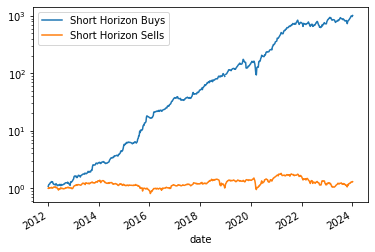

In [45]:
shor_buys = shor_buys.reset_index(level=0, drop=True)
shor_sells = shor_sells.reset_index(level=0, drop=True)
(1+shor_buys).cumprod().plot(label="Short Horizon Buys")
(1+shor_sells).cumprod().plot(label="Short Horizon Sells")
plt.legend()
plt.yscale('log')
plt.show()

#### Long-horizon buy/sell portfolios

In [46]:
lhor_sells = rets.loc[(0,slice(None)),0]
lhor_buys = rets.loc[(4,slice(None)),0]

In [47]:
print(f'Buy Avg Ret:\t{lhor_buys.mean():.4f}')
print(f'Sell Avg Ret:\t{shor_sells.mean():.4f}')

Buy Avg Ret:	0.0100
Sell Avg Ret:	0.0008


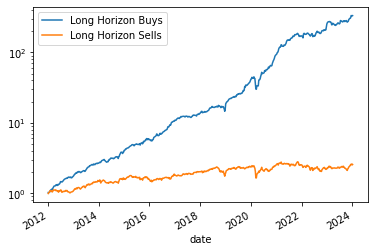

In [48]:
lhor_buys = lhor_buys.reset_index(level=0, drop=True)
lhor_sells = lhor_sells.reset_index(level=0, drop=True)
(1+lhor_buys).cumprod().plot(label="Long Horizon Buys")
(1+lhor_sells).cumprod().plot(label="Long Horizon Sells")
plt.legend()
plt.yscale('log')
plt.show()